### Hw3

#### 4. The Data

In [1]:
from load import shuffle_data

In [2]:
shuffled_data = shuffle_data()

In [3]:
# split to train and validation data
train_data = shuffled_data[:1500]
val_data = shuffled_data[1500:]

In [4]:
# sep X and y
X_train = [rec[:-1] for rec in train_data]
y_train = [rec[-1] for rec in train_data]
X_val = [rec[:-1] for rec in val_data]
y_val = [rec[-1] for rec in val_data]

#### 5. Sparse Representation

In [5]:
from collections import Counter
def bag_words(words):
    return Counter(words)

In [6]:
# test it
bag_words(X_train[0])

Counter({'if': 6,
         'i': 23,
         'were': 3,
         'one': 4,
         'of': 21,
         'those': 1,
         'arrogant': 1,
         'critics': 1,
         'who': 4,
         'thinks': 1,
         'his': 5,
         'review': 2,
         'has': 3,
         'some': 4,
         'great': 1,
         'impact': 1,
         'on': 6,
         'the': 57,
         'success': 1,
         'or': 5,
         'failure': 1,
         'certain': 1,
         'films': 1,
         'might': 3,
         'say': 4,
         'that': 18,
         'movies': 5,
         "don't": 5,
         'look': 1,
         'particularly': 1,
         'good': 3,
         'because': 4,
         "i'm": 3,
         'doing': 1,
         'a': 39,
         'service': 1,
         'to': 30,
         'my': 2,
         'readers': 1,
         'by': 3,
         'warning': 1,
         'them': 5,
         'against': 1,
         'seeing': 5,
         'it': 14,
         'true': 1,
         'could': 2,
         'put': 1,
       

#### 6. Support Vector Machine via Pegasos

##### 6.4 Pegasos

In [11]:
from collections import defaultdict
from util import dotProduct, increment

def pegasos(X_train, y_train, max_step=1000, lamb_reg=0.1):
    epoch = 0
    t = 1
    w = defaultdict(float)
    while epoch < max_step:
        epoch += 1
        for i, x_i in enumerate(X_train):
            t += 1
            eta = 1 / (t * lamb_reg)
            x_i = bag_words(x_i)
            y_i = y_train[i]
            increment(w, -eta * lamb_reg, w)
            if y_i * dotProduct(w, x_i) < 1:
                increment(w, eta*y_i, x_i)
    return w

##### 6.5 Pegasos Accelerated

In [12]:
def pegasos_accelerated(X_train, y_train, max_step=1000,
                        lamb_reg=0.1, tolerence=1e-4):
    epoch = 0
    t = 1
    s_t = 1
    W = defaultdict(float)
    while epoch < max_step:
        epoch += 1
        # for convergence checking
        check_w = defaultdict(float)
        for i, x_i in enumerate(X_train):
            t += 1
            x_i = bag_words(x_i)
            eta = 1 / (t * lamb_reg)
            y_i = y_train[i]
            s_t = (1 - eta * lamb_reg) * s_t
            if y_i * dotProduct(W, x_i) < 1:
                increment(W, (1/s_t) * eta * y_i, x_i)
                increment(check_w, (1/s_t) * eta * y_i, x_i)
        if sum(weight**2 for weight in check_w.values()) < tolerence:
            print(f"Pegasos converge at epoch {epoch}")
            break
    W.update((x, y*s_t) for x, y in W.items())
    return W

##### 6.6 Check
这里得到的结果并不一样...并没有找出错误的地方Orz

In [16]:
w = pegasos(X_train, y_train, 2)
w_acc = pegasos_accelerated(X_train, y_train, 2)

In [19]:
w['fame'], w_acc['fame']

(0.028664755682954415, 0.01866542230517956)

##### 6.7 Evaluate

In [106]:
import numpy as np

def evaluate(w, X_val, y_val):
    n = len(y_val)
    count = 0
    for i in range(n):
        x_i = bag_words(X_val[i])
        y_i = y_val[i]
        if np.sign(dotProduct(w, x_i)) == y_i:
            count += 1
    return count / n

In [107]:
w = pegasos_accelerated(X_train, y_train)

Pegasos converge at epoch 25


In [108]:
# 准确率
evaluate(w, X_val, y_val)

0.832

##### 6.8 Best $\lambda$

In [114]:
import matplotlib.pyplot as plt

def plot_lambda_precision(lamb_regs,
                          X_train=X_train, y_train=y_train,
                          X_val=X_val, y_val=y_val, max_step=500):
    precision = []
    for lamb_reg in lamb_regs:
        w = pegasos_accelerated(X_train, y_train, max_step, lamb_reg)
        precision.append(evaluate(w, X_val, y_val))
    plt.plot(lamb_regs, precision)
    plt.grid()
    plt.xlabel("$\lambda$")
    plt.ylabel("Prediction")
    plt.show()

Pegasos converge at epoch 25
Pegasos converge at epoch 25
Pegasos converge at epoch 25
Pegasos converge at epoch 25
Pegasos converge at epoch 32


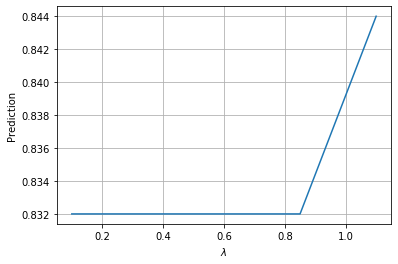

In [115]:
# turn 1
plot_lambda_precision(np.linspace(0.1, 1.1, 5))

Pegasos converge at epoch 25
Pegasos converge at epoch 32
Pegasos converge at epoch 23
Pegasos converge at epoch 22
Pegasos converge at epoch 29


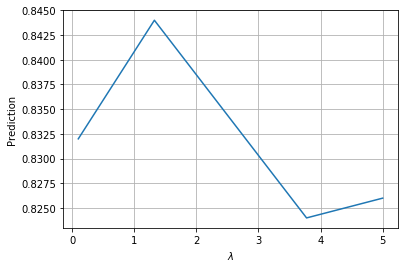

In [116]:
# turn 2
plot_lambda_precision(np.linspace(0.1, 5, 5))

Pegasos converge at epoch 27
Pegasos converge at epoch 32
Pegasos converge at epoch 32
Pegasos converge at epoch 32
Pegasos converge at epoch 31


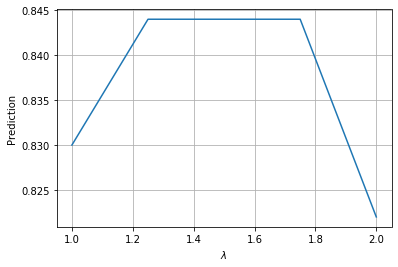

In [117]:
# turn 4
plot_lambda_precision(np.linspace(1, 2, 5))

因此，最优的$\lambda$在1.3~1.7之间。

In [119]:
best_lamb_reg = 1.3

#### 7. Error Analysis

In [118]:
def get_wrong_samples(w, X_val, y_val):
    n = len(y_val)
    wrongs = []
    for i in range(n):
        x_i = bag_words(X_val[i])
        y_i = y_val[i]
        if np.sign(dotProduct(w, x_i)) != y_i:
            wrongs.append(i)
    return wrongs

In [121]:
w = pegasos_accelerated(X_train, y_train, max_step=1000, best_lamb_reg)
wrongs = get_wrong_samples(w, X_val, y_val)

Pegasos converge at epoch 32


In [123]:
len(wrongs)

78

In [139]:
import operator, collections

def error_analysis(index=0):
    wrong_sample_X = X_train[wrongs[index]]
    wrong_sample_y = y_train[wrongs[index]]
    contributions = defaultdict(float)
    x_i = bag_words(wrong_sample_X)
    for feature in x_i.keys():
        contributions[feature] = np.abs(w[feature] * x_i[feature])
    sorted_contribution = sorted(contributions.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_contribution

In [140]:
error_analysis(0)

[('the', 0.00807675481119783),
 ('of', 0.007932527046712112),
 ('any', 0.007547919674750327),
 ('and', 0.006538325323350568),
 ('this', 0.00608961672272855),
 ('is', 0.005624882814941373),
 ('if', 0.005384503207465199),
 ('at', 0.005288351364474801),
 ('as', 0.004487086006221),
 ('once', 0.004278757013075039),
 ('point', 0.004198630477249663),
 ('only', 0.004086453327094132),
 ('television', 0.003910174948278307),
 ('simply', 0.0038941496411132406),
 ('himself', 0.003269162661675305),
 ('his', 0.003044808361364257),
 ('he', 0.0028525046753833344),
 ('but', 0.0026922516037325974),
 ('that', 0.002564049146412033),
 ('life', 0.0024678973034215537),
 ('to', 0.00229161892460573),
 ('when', 0.0022755936174406423),
 ('very', 0.0022595683102755843),
 ('through', 0.0021794417744502026),
 ('each', 0.0021794417744502013),
 ('who', 0.002163416467285147),
 ('attempt', 0.0021153405457899057),
 ('movie', 0.002115340545789904),
 ('way', 0.002083289931459753),
 ('different', 0.0020352140099645297),
 ('

In [141]:
error_analysis(1)

[('and', 0.006538325323350568),
 ('that', 0.005640908122106473),
 ('the', 0.004487086006221016),
 ('love', 0.0036537700336370894),
 ('sex', 0.0032691626616753195),
 ('between', 0.0030287830541991874),
 ('on', 0.003012757747034084),
 ('evil', 0.0028845552897135136),
 ('as', 0.0022435430031105),
 ('is', 0.0018749609383137912),
 ('best', 0.0018589356311486933),
 ('one', 0.0018108597096534807),
 ('austin', 0.0016826572523328696),
 ('about', 0.001666631945167799),
 ('relationship', 0.0016345813308376628),
 ('are', 0.001602530716507483),
 ('do', 0.0015224041806821225),
 ("it's", 0.0014903535663519734),
 ('scene', 0.001282024573205999),
 ('female', 0.0012339486517107783),
 ('this', 0.00121792334454571),
 ('leading', 0.0012179233445457085),
 ('make', 0.001217923344545706),
 ('will', 0.0012179233445457007),
 ('real', 0.001201898037380632),
 ('gun', 0.0011858727302155537),
 ('because', 0.001169847423050481),
 ('bit', 0.0011377968087203324),
 ('scott', 0.0011057461943901818),
 ('himself', 0.00108

可以看到贡献最大的单词均为常用词(`and`, `that`, `the`等)，其不含明确的感情色彩，一般我们将此类词标记为停用词排除。